In [1]:
!pip install tsaug
!pip install pykalman

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import tsaug
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
from pykalman import KalmanFilter
from sklearn.decomposition import PCA

_Generation of a random signal initially_

In [3]:
a = np.arange(100)

In [4]:
s1 = np.sin(a*math.pi/6)
s2 = np.sin(a*math.pi/3+100)
s3 = np.sin(a*math.pi/2+200)
sig = s1+s2+s3

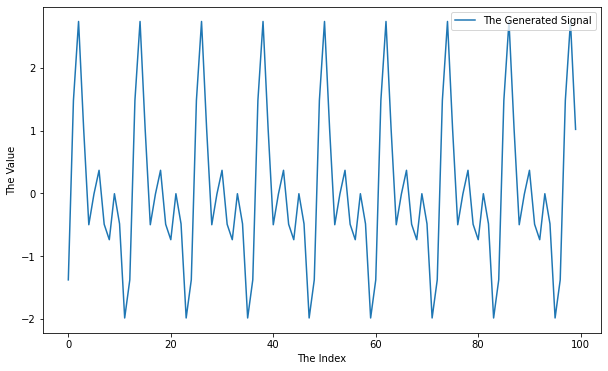

In [5]:
plt.figure(figsize = (10,6) )
plt.plot(sig, label = "The Generated Signal")
plt.xlabel("The Index")
plt.ylabel("The Value")
plt.legend()

_Augmentation of the signal_

In [6]:
augmented1 = tsaug.AddNoise(scale=0.3).augment(sig)
augmented2 = tsaug.Drift(max_drift=0.7, n_drift_points=5).augment(sig)
augmented3 = tsaug.TimeWarp(n_speed_change=1, max_speed_ratio=3).augment(sig)
augmented4 = tsaug.Pool(size=2).augment(sig)

augmented = np.array([augmented1, augmented2, augmented3, augmented4])

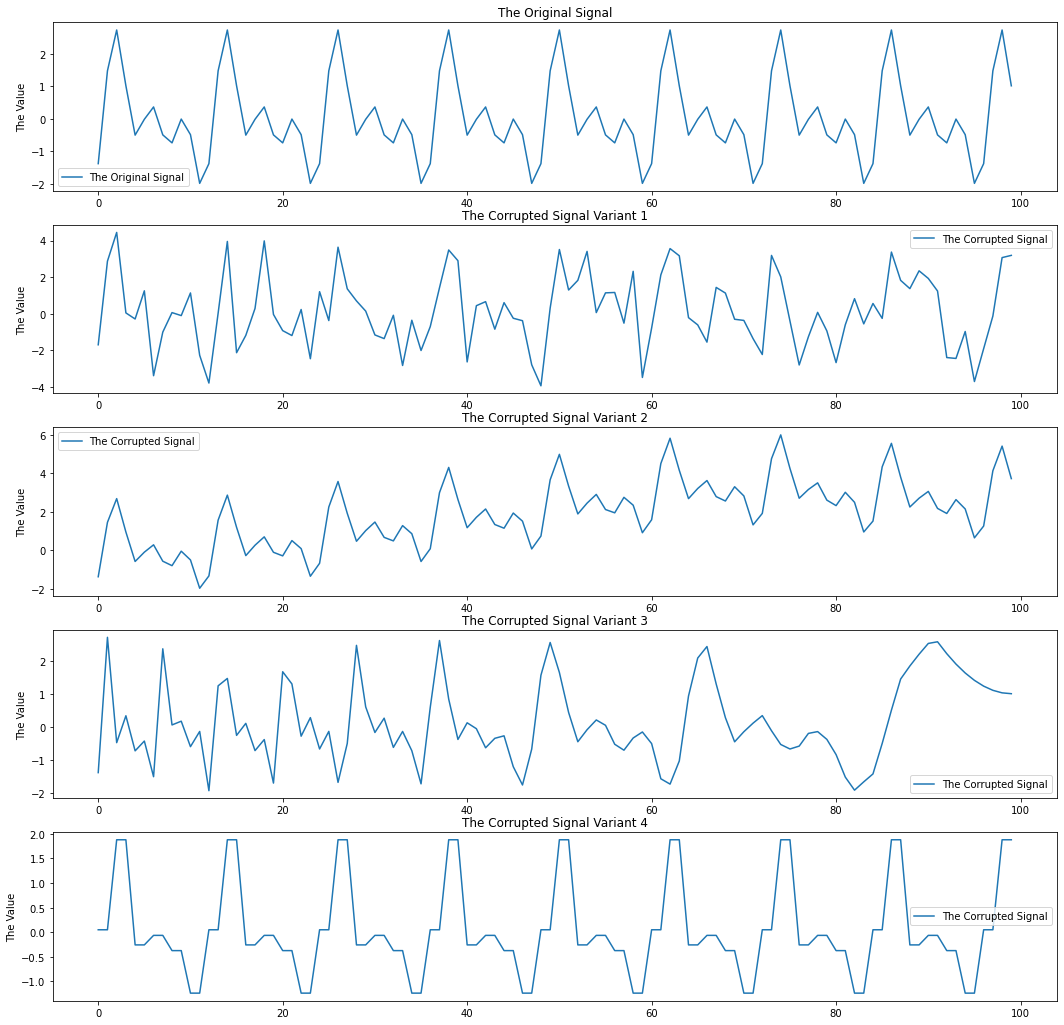

In [7]:
plt.figure(figsize = (18,18) )

plt.subplot(5, 1, 1)
plt.plot(sig, label = "The Original Signal")
plt.ylabel("The Value")
plt.title("The Original Signal")
plt.legend()

plt.subplot(5,1,2)
plt.plot(augmented1, label = "The Corrupted Signal")
plt.ylabel("The Value")
plt.title("The Corrupted Signal Variant 1")
plt.legend()

plt.subplot(5,1,3)
plt.plot(augmented2, label = "The Corrupted Signal")
plt.ylabel("The Value")
plt.title("The Corrupted Signal Variant 2")
plt.legend()

plt.subplot(5,1,4)
plt.plot(augmented3, label = "The Corrupted Signal")
plt.ylabel("The Value")
plt.title("The Corrupted Signal Variant 3")
plt.legend()

plt.subplot(5,1,5)
plt.plot(augmented4, label = "The Corrupted Signal")
plt.ylabel("The Value")
plt.title("The Corrupted Signal Variant 4")
plt.legend()






_We corrupted each signal, so let us try to compute the correlation scores of each to see how similar are they to the original signal that we have_

In [8]:
for i in range(4):
    res = np.corrcoef(sig, augmented[i])
    print("Correlation Score with the original signal and Corrupted Signal is: " + str(res[0][1]))

Correlation Score with the original signal and Corrupted Signal is: 0.6728726954865621
Correlation Score with the original signal and Corrupted Signal is: 0.7201730931143037
Correlation Score with the original signal and Corrupted Signal is: 0.13160814840060836
Correlation Score with the original signal and Corrupted Signal is: 0.7637462335021996


_Here we can see that the original signal is not that close to the generated corrupted signals, therefore we can start trying to utilize the sensor fusion methods that we have to get a signal closer to the original from the corrupted ones_

In [9]:
kf = KalmanFilter(n_dim_obs=100,n_dim_state=100)
kf = kf.em(augmented, n_iter=20)
(filtered_state_means, filtered_state_covariances) = kf.filter(augmented)

In [10]:
for i in range(4):
    res = np.corrcoef(sig, filtered_state_means[i])
    print("Correlation Score with the original signal and Corrupted Signal is: " + str(res[0][1]))

Correlation Score with the original signal and Corrupted Signal is: 0.757477337657891
Correlation Score with the original signal and Corrupted Signal is: 0.730751396543371
Correlation Score with the original signal and Corrupted Signal is: 0.6765061471190036
Correlation Score with the original signal and Corrupted Signal is: 0.6957304300433247


_Here we can see that the time-warped signal we collected was having a correlation score of 0.06 in the beginning, but by using the correction, after filtering we can see that the correlation score becomes 0.6 which is 10 times better. Let's visualize the new signal._

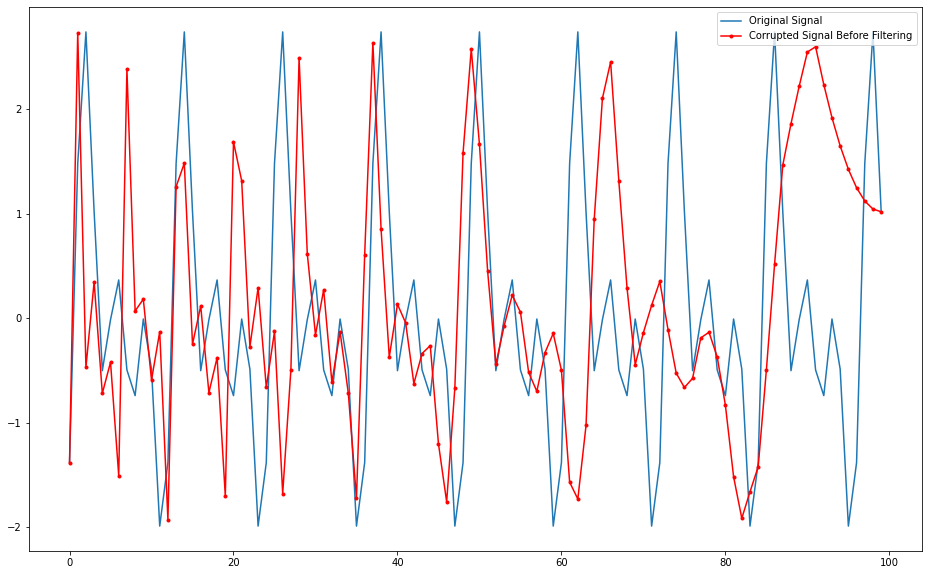

In [13]:
plt.figure( figsize = (16,10)  )
plt.plot(sig, label = "Original Signal")
plt.plot(augmented[2], "r.-", label = "Corrupted Signal Before Filtering")
#plt.plot(filtered_state_means[2], label = "Corrupted Signal Corrected with Filter")
plt.legend()

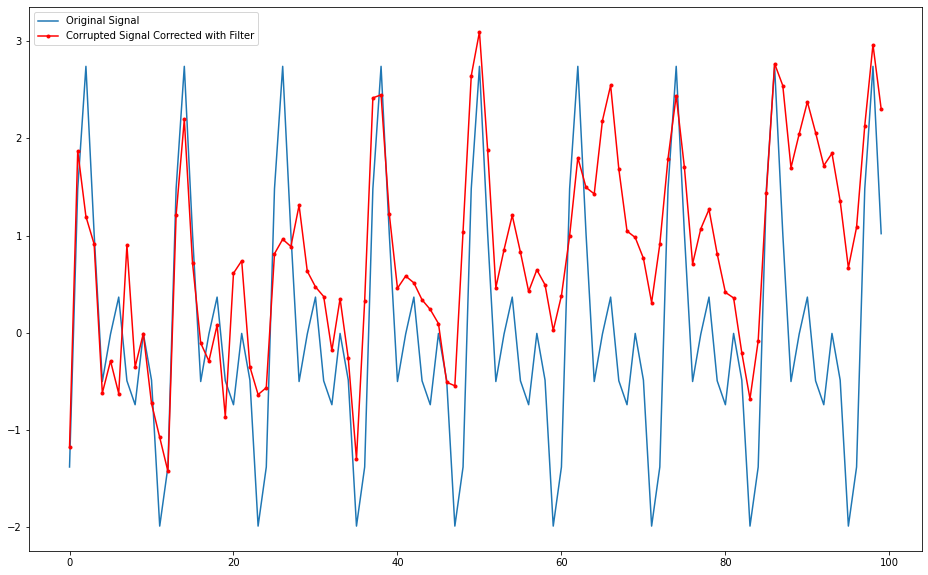

In [19]:
plt.figure( figsize = (16,10)  )
plt.plot(sig, label = "Original Signal")
#plt.plot(augmented[2], label = "Corrupted Signal Before Filtering")
plt.plot(filtered_state_means[2],  "r.-",label = "Corrupted Signal Corrected with Filter")
plt.legend()

_Here we can observe that the signal was not similar to the original signal in the first samples before filtering it, but after filtering it became very similar._

_Another method that we can use right now can be called PCA, by basically taking the principal components of the signals we can generate better signals. Let's try that approach as well and lets check what we can have._

In [15]:
pca = PCA(n_components =2)

In [16]:
pca_sig = augmented
pca_sig = pca.fit(pca_sig).transform(pca_sig)
pca_sig = pca.inverse_transform(pca_sig)

In [17]:
for i in range(4):
    res = np.corrcoef(sig, pca_sig[i])
    print("Correlation Score with the original signal and Corrupted Signal is: " + str(res[0][1]))

Correlation Score with the original signal and Corrupted Signal is: 0.7073789087787902
Correlation Score with the original signal and Corrupted Signal is: 0.7215504768471876
Correlation Score with the original signal and Corrupted Signal is: 0.1838715525481605
Correlation Score with the original signal and Corrupted Signal is: 0.735459178965898


In [18]:
for i in range(4):
    res = np.corrcoef(sig, augmented[i])
    print("Correlation Score with the original signal and Corrupted Signal is: " + str(res[0][1]))

Correlation Score with the original signal and Corrupted Signal is: 0.6728726954865621
Correlation Score with the original signal and Corrupted Signal is: 0.7201730931143037
Correlation Score with the original signal and Corrupted Signal is: 0.13160814840060836
Correlation Score with the original signal and Corrupted Signal is: 0.7637462335021996


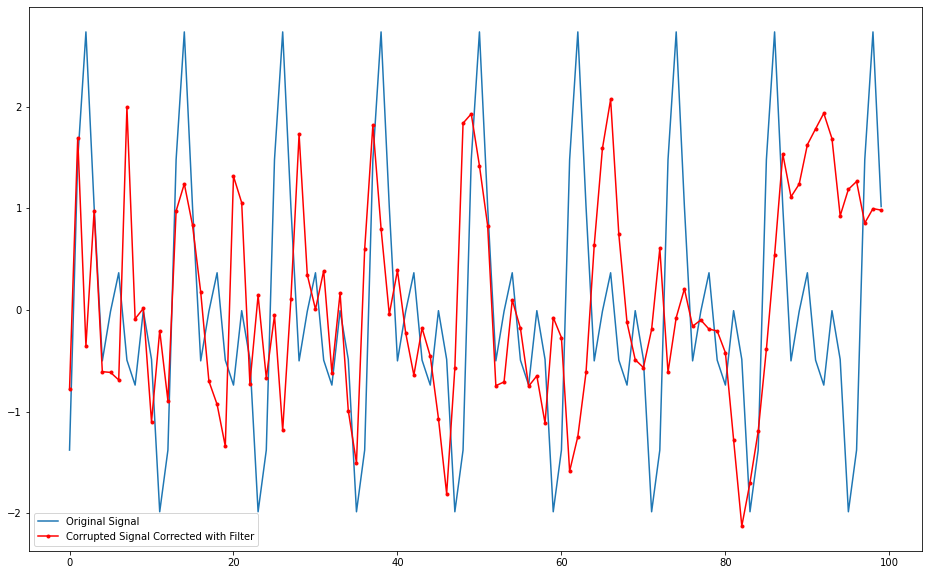

In [21]:
plt.figure( figsize = (16,10)  )
plt.plot(sig, label = "Original Signal")
#plt.plot(augmented[2], label = "Corrupted Signal Before Filtering")
plt.plot(pca_sig[2],  "r.-",label = "Corrupted Signal Corrected with Filter")
plt.legend()

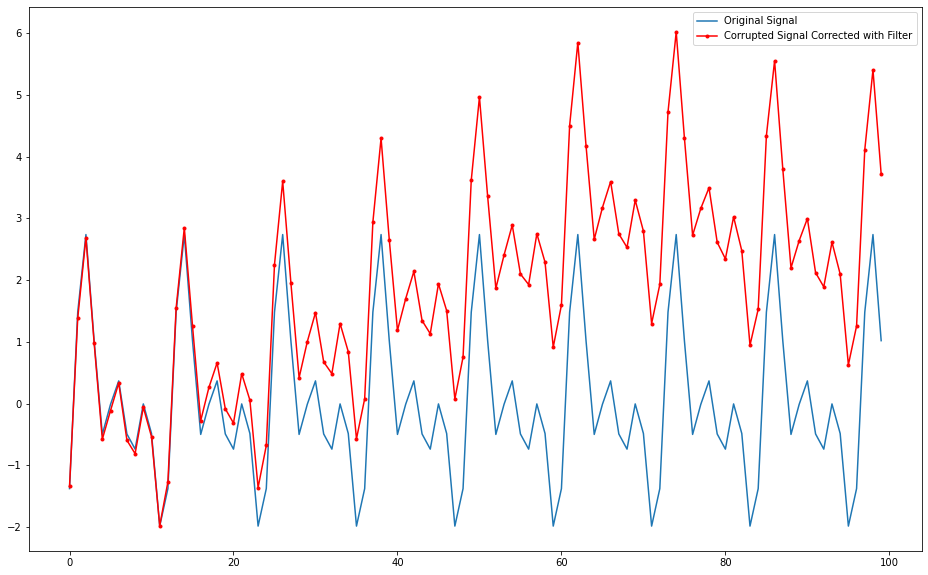

In [22]:
plt.figure( figsize = (16,10)  )
plt.plot(sig, label = "Original Signal")
#plt.plot(augmented[2], label = "Corrupted Signal Before Filtering")
plt.plot(pca_sig[1],  "r.-",label = "Corrupted Signal Corrected with Filter")
plt.legend()